![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
!pip install lightgbm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación librerías
%matplotlib inline
import pandas as pd
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import datetime

In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [6]:
dataTraining['Make'] = dataTraining['Make'].astype('category')
dataTraining['Model'] = dataTraining['Model'].astype('category')
dataTraining['State'] = dataTraining['State'].astype('category')
dataTraining.dtypes

Price         int64
Year          int64
Mileage       int64
State      category
Make       category
Model      category
dtype: object

In [7]:
dataTraining.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [8]:
dataTraining.shape

(400000, 6)

### Exploración de datos

In [9]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [10]:
dataTraining.shape

(400000, 6)

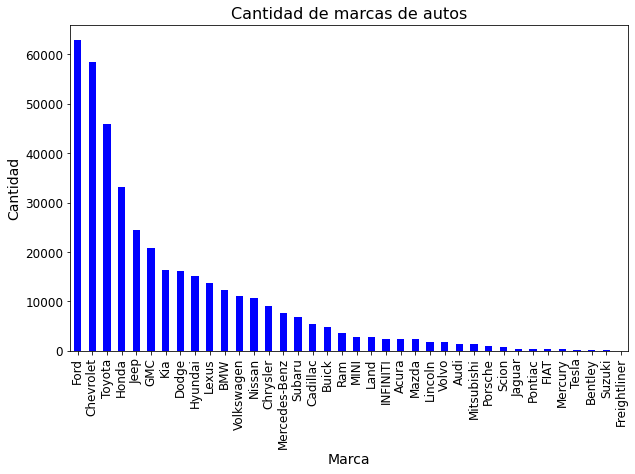

In [11]:
conteo_make = dataTraining['Make'].value_counts()
conteo_make.plot.bar(figsize=(10,6), fontsize=12, color='blue')
plt.title('Cantidad de marcas de autos', fontsize=16)
plt.xlabel('Marca', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.show()

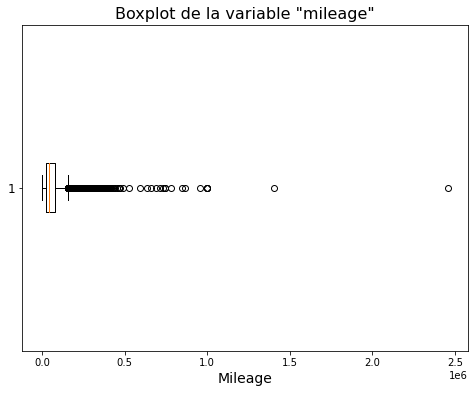

In [12]:
plt.figure(figsize=(8, 6))
plt.boxplot(dataTraining['Mileage'], vert=False)
plt.title('Boxplot de la variable "mileage"', fontsize=16)
plt.xlabel('Mileage', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

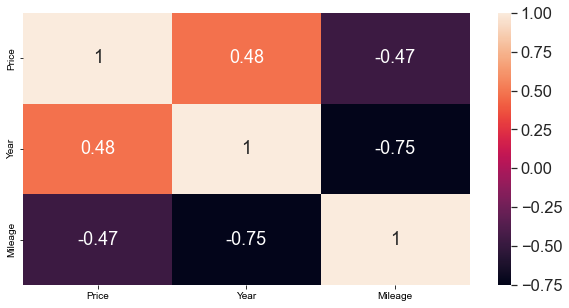

In [13]:
MatrixCorrelacion = dataTraining.corr()

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.5)  

sns.heatmap(MatrixCorrelacion, annot=True, ax=ax)
plt.show()

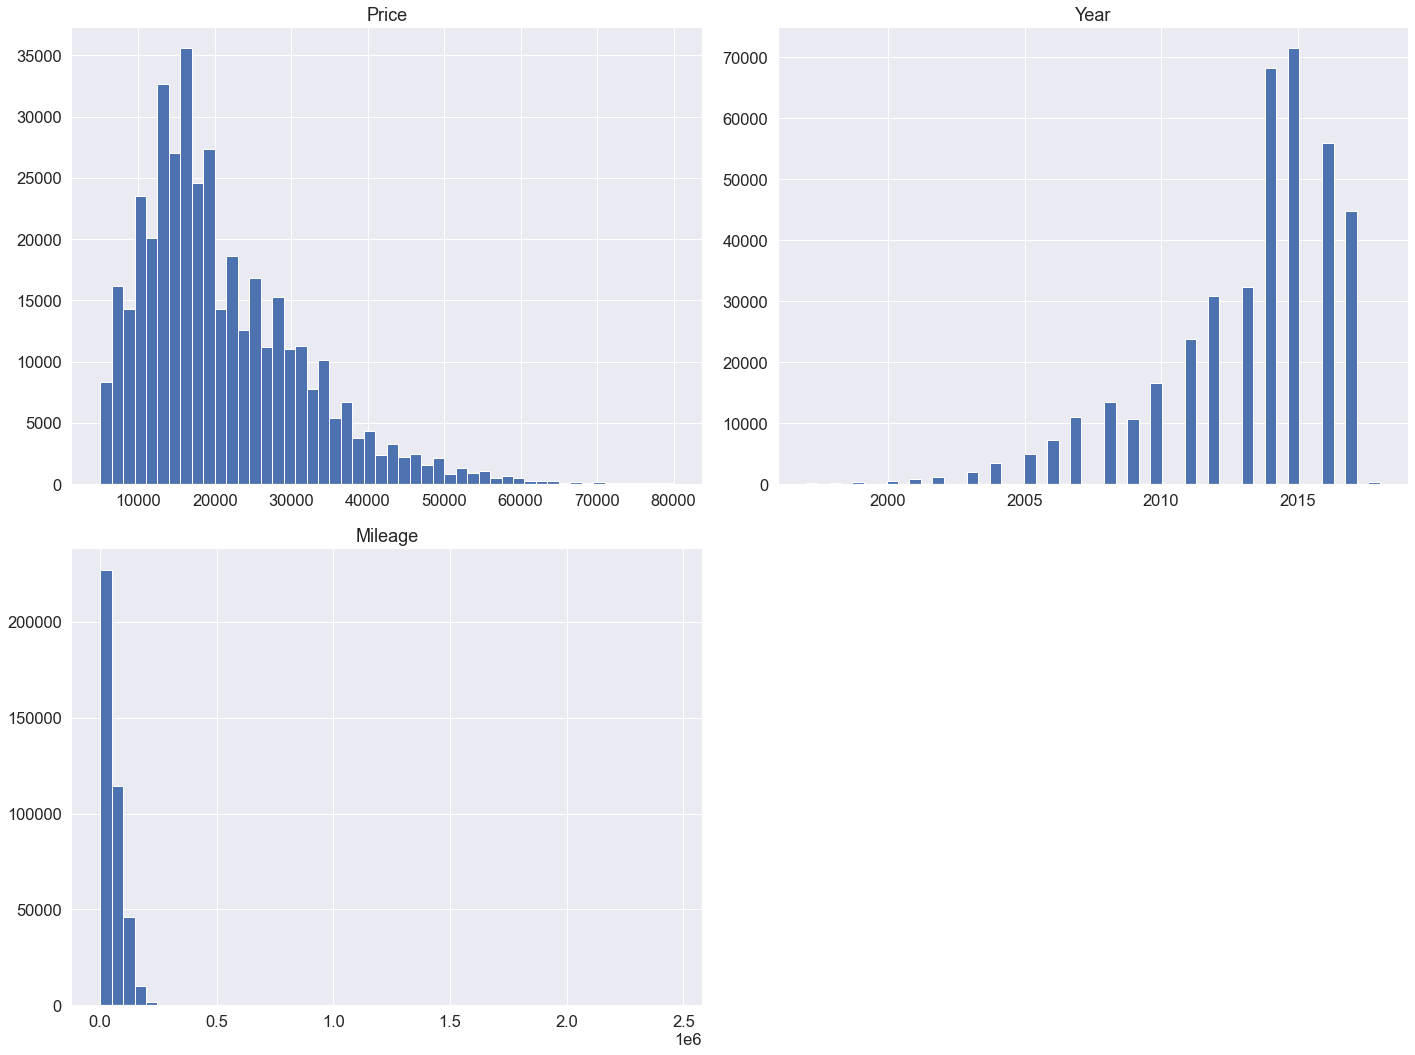

In [14]:
# Histograma para todas las variables numéricas incluyendo la variable de respuesta
dataTraining.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

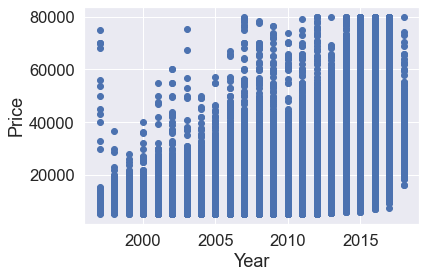

In [15]:
plt.scatter(dataTraining.Year,dataTraining.Price)
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

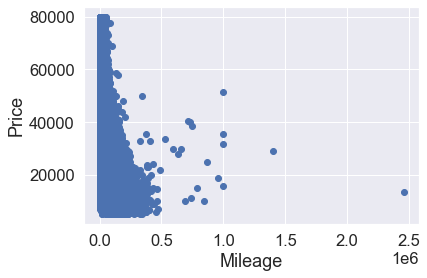

In [16]:
plt.scatter(dataTraining.Mileage,dataTraining.Price)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

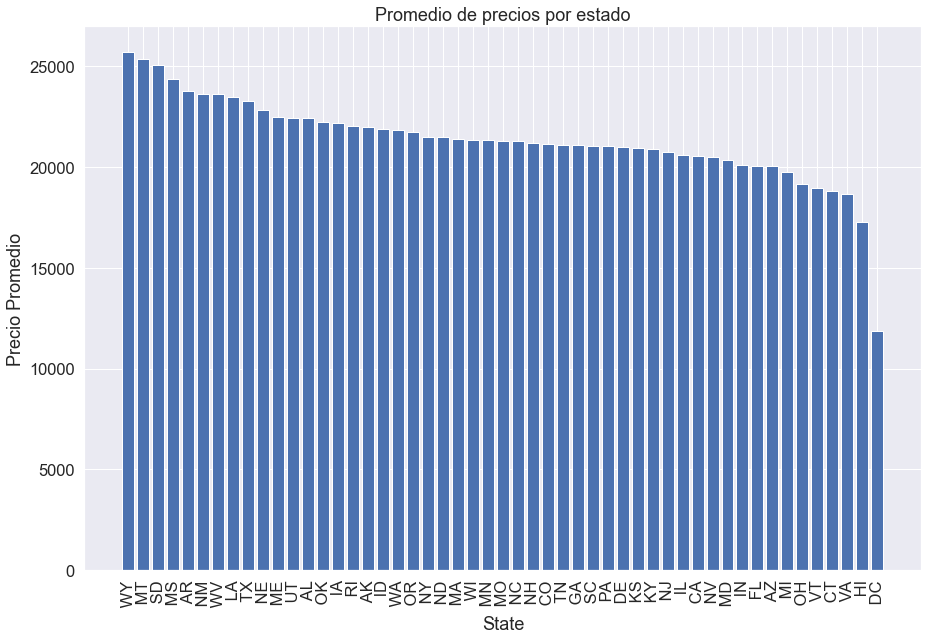

In [17]:
# Agrupamos por Estado y calculamos el promedio de los precios
data = dataTraining.groupby('State')['Price'].mean()

# Ordenamos los valores de mayor a menor
data = data.sort_values(ascending=False)

# Creamos la gráfica de barras
plt.figure(figsize=(15,10))
plt.bar(data.index, data.values)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Precio Promedio')
plt.title('Promedio de precios por estado')
plt.show()

### Preprocesamiento de datos

#### Edad del vehículo

In [18]:
time_now = datetime.datetime.now()
dataTraining['Age'] = dataTraining['Year'].apply(lambda x : time_now.year - x)
dataTraining = dataTraining.drop(['Year'], axis=1)

#### Eliminación de duplicados

In [19]:
# Eliminar duplicados
duplicados = dataTraining.duplicated()
print("Número total de duplicados en el DataFrame: ", duplicados.sum())

Número total de duplicados en el DataFrame:  169


In [20]:
dataTraining = dataTraining.drop_duplicates()

In [21]:
dataTraining.head()

,Price,Mileage,State,Make,Model,Age
0,34995,9913,FL,Jeep,Wrangler,6
1,37895,20578,OH,Chevrolet,Tahoe4WD,8
2,18430,83716,TX,BMW,X5AWD,11
3,24681,28729,OH,Cadillac,SRXLuxury,9
4,26998,64032,CO,Jeep,Wrangler,10


#### Eliminación de valores atípicos

In [22]:
# VALORES ATÍPICOS PARA MILEAGE
# Calcular el rango intercuartil (IQR)
Q1 = dataTraining['Mileage'].quantile(0.25)
Q3 = dataTraining['Mileage'].quantile(0.75)
IQR = Q3 - Q1

# Eliminar los valores atípicos utilizando el método del rango intercuartil (IQR)
dataTraining = dataTraining[~((dataTraining['Mileage'] < (Q1 - 1.5 * IQR)) | (dataTraining['Mileage'] > (Q3 + 1.5 * IQR)))]

In [23]:
dataTraining.head()

,Price,Mileage,State,Make,Model,Age
0,34995,9913,FL,Jeep,Wrangler,6
1,37895,20578,OH,Chevrolet,Tahoe4WD,8
2,18430,83716,TX,BMW,X5AWD,11
3,24681,28729,OH,Cadillac,SRXLuxury,9
4,26998,64032,CO,Jeep,Wrangler,10


#### Estandarización Mileage en data Training y Testing

In [24]:
# Fit transform

scaler = StandardScaler()
scaler.fit(dataTraining[['Mileage']])
dataTraining[['Mileage']] = scaler.transform(dataTraining[['Mileage']])
dataTesting[['Mileage']] = scaler.transform(dataTesting[['Mileage']])

#### Dummies

##### Marca

In [25]:
# Eliminar espacios en la columna "Make"
dataTraining["Make"] = dataTraining["Make"].apply(lambda x: x.strip())

############################## Dummies para Marca ####################################
dummies = pd.get_dummies(dataTraining['Make'], prefix='Make')
dummies=dummies.drop('Make_Freightliner', axis=1)
dataTraining = pd.concat([dataTraining, dummies], axis=1)

##### Modelo
En el caso de la variable modelo, se crea una variable dummie teniendo en cuenta la media del precio para un modelo específico. Después se mapean esas particiones para asignar la misma dummie en la data de testing.

In [26]:
######################## Dummies para los modelos ##########################

# Crear un diccionario vacío para almacenar los resultados
promedios_por_modelo = {}

# Recorrer los valores distintos de la columna "Model"
for model in dataTraining["Model"].unique():
    # Obtener el promedio de la columna "Price" para los registros donde "Model" es igual a la marca actual
    promedio = dataTraining.loc[dataTraining["Model"] == model, "Price"].mean()
    # Agregar la marca y su promedio al diccionario
    promedios_por_modelo[model] = promedio
diccionario_ordenado = dict(sorted(promedios_por_modelo.items(), key=lambda x: x[1], reverse=True))

In [27]:
k = 100
column_names = []
for i in range(0, 80000, int(80000/k)):
    name = f"{i}-{i+int(80000/k)}"
    column_names.append(name)

# Creamos las columnas con el nombre de la partición en el dataframe
for i in range(len(column_names)):
    dataTraining[column_names[i]]=0

# Creamos diccionario con el rango de precios como llaves y los modelos que se encuentran en ese rango como valores
rango_precios = {}

for column in column_names:
    start, end = column.split("-")
    start, end = int(start), int(end)
    rango_precios[column] = [key for key, value in diccionario_ordenado.items() if start <= value <= end]

# Validar si el valor de la columna Model está en el diccionario rango_precios
for i, row in dataTraining.iterrows():
    model = row['Model']
    for key, value in rango_precios.items():
        if model in value:
            dataTraining.at[i, key] = 1

##### Estado

In [28]:
# Eliminar espacios en la columna "State"
dataTraining["State"] = dataTraining["State"].apply(lambda x: x.strip())

############################## Dummies para State ####################################
dummies = pd.get_dummies(dataTraining['State'], prefix='State')
dataTraining = pd.concat([dataTraining, dummies], axis=1)

dataTraining = dataTraining.drop(['State', 'Make', 'Model'], axis=1)

#### Transformación variable "Price"
En la gráfica a continuación, se puede observar que la distribución de la variable "Price" es asimétrica hacia la derecha. Por lo tanto, para la construcción del modelo se transforma la variable de respuesta con el logaritmo y después se aprecia que la distribución de la variable es casi normal.

<AxesSubplot:xlabel='Price', ylabel='Density'>

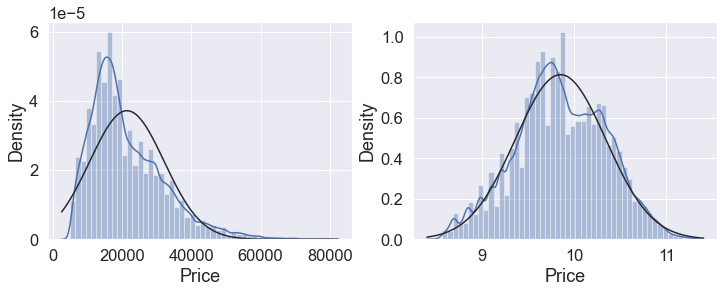

In [29]:
from scipy.stats import norm
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(dataTraining['Price'], ax=ax[0], fit=norm)
sns.distplot(np.log(dataTraining[('Price')]+1), ax=ax[1], fit= norm)

In [30]:
dataTraining['Price'] = np.log1p(dataTraining['Price'])

#### Separación de datos en set de entrenamiento y test

In [31]:
# Separación de variables predictoras (X) y variable de interés (y)
y = dataTraining['Price']
X = dataTraining.drop(['Price'], axis=1)

# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Calibración del modelo

#### XGBoost

##### Estimators

In [ ]:
# Calibración n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(100, 400, 50)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb = XGBRegressor(n_estimators=estimator, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [ ]:
nEstimators = estimator_range[accuracy_scores.index(max(accuracy_scores))]
nEstimators

##### Subsample

In [ ]:
# Calibración subsample
# Creación de lista de valores para iterar sobre diferentes valores de subsample
subsample_range = np.arange(0.1, 1.1, 0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de subsample
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de subsample
for subsample in subsample_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=subsample, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de subsample
plt.plot(subsample_range, accuracy_scores)
plt.xlabel('Subsample')
plt.ylabel('Accuracy')

In [ ]:
nSubsample = subsample_range[accuracy_scores.index(max(accuracy_scores))]
nSubsample

##### Max_depth

In [ ]:
# Calibración max_depth
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 11)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de subsample
for depth in depth_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=depth, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [ ]:
nDepth = depth_range[accuracy_scores.index(max(accuracy_scores))]
nDepth

##### Learning rate

In [ ]:
# Calibración learning_rate
# Creación de lista de valores para iterar sobre diferentes valores de learning_rate
learning_rate_range = np.arange(0.1, 1.1, 0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de learning_rate
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de learning_rate
for learning_rate in learning_rate_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=nDepth, learning_rate=learning_rate,
                       random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(learning_rate_range, accuracy_scores)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')

In [ ]:
nLearningRate = learning_rate_range[accuracy_scores.index(max(accuracy_scores))]
nLearningRate

##### Gamma

In [ ]:
# Calibración gamma
# Creación de lista de valores para iterar sobre diferentes valores de gamma
gamma_range = range(0, 10, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de gamma
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de gamma
for gamma in gamma_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=nDepth, learning_rate=nLearningRate,
                       gamma=gamma, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de gamma
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

In [ ]:
nGamma = gamma_range[accuracy_scores.index(max(accuracy_scores))]
nGamma

##### Colsample_bytree

In [ ]:
# Calibración colsample_bytree
# Creación de lista de valores para iterar sobre diferentes valores de colsample_bytree
colsample_bytree_range = np.arange(0, 1.1, 0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de colsample_bytree
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de colsample_bytree
for colsample_bytree in colsample_bytree_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=nDepth, learning_rate=nLearningRate,
                        gamma=nGamma, colsample_bytree=colsample_bytree, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de gamma
plt.plot(colsample_bytree_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')

In [ ]:
nColsample = colsample_bytree_range[accuracy_scores.index(max(accuracy_scores))]
nColsample

### Entrenamiento del modelo

#### XGBoost

In [ ]:
xgb = XGBRegressor(n_jobs=-1)
xgb.fit(X_train, y_train)

In [ ]:
#Impresión de desempeño del modelo
y_pred = xgb.predict(X_test)
y_pred

In [ ]:
y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)

In [ ]:
# RMSE
xgb_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %xgb_RMSE )
# MAE
xgb_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %xgb_MAE )

#### LightGBM

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [ ]:
y_test = np.log1p(y_test)

In [ ]:
lgbm = LGBMRegressor(**hyper_params)
lgbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

In [ ]:
#Impresión de desempeño del modelo
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)

In [ ]:
y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)

In [ ]:
# RMSE
lgbm_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %lgbm_RMSE )
# MAE
lgbm_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %lgbm_MAE )

### Transformación de variables en testing

In [ ]:
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting['Age'] = dataTesting['Year'].apply(lambda x : time_now.year - x)
dataTesting = dataTesting.drop(['Year'], axis=1)

In [ ]:
# Fit transform

scaler = StandardScaler()
scaler.fit(dataTraining[['Mileage']])
dataTraining[['Mileage']] = scaler.transform(dataTraining[['Mileage']])
dataTesting[['Mileage']] = scaler.transform(dataTesting[['Mileage']])

In [ ]:
########################### Dummies marca ########################################
dummies = pd.get_dummies(dataTesting['Make'], prefix='Make')
dataTesting = pd.concat([dataTesting, dummies], axis=1)

########################### Dummies modelo #######################################

# Creamos las columnas con el nombre de la partición en el dataframe

for i in range(len(column_names)):
    dataTesting[column_names[i]]=0

# Validar si el valor de la columna Model está en el diccionario rango_precios
for i, row in dataTesting.iterrows():
    model = row['Model']
    for key, value in rango_precios.items():
        if model in value:
            dataTesting.at[i, key] = 1

############################## Dummies para State ####################################
dummies = pd.get_dummies(dataTesting['State'], prefix='State')
dataTesting = pd.concat([dataTesting, dummies], axis=1)
            
dataTesting=dataTesting.drop(['State', 'Make','Model'], axis=1)

### Resultados

In [ ]:
y_pred=lgbm.predict(dataTesting, num_iteration=lgbm.best_iteration_)
y_pred = np.expm1(y_pred)
y_pred=pd.DataFrame(y_pred,columns=['Price'])

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()